# LSTM for PM 2.5 estimations

Particulate Matter (PM) of size 2.5 µm are known to have significant health effects. Due to limited spatial and temporal coverage of surface PM 2.5 monitors, using data from geostationary satellites to estimate the surface levels can prove beneficial. In addition, meteorlogical factors that affect the surface PM2.5 levels may also help in generating more accurate estimations. 

### Dataset sources
<ul>
<li>GOES-R Aerosol Optical Depth Products</li>
<li>NOAA High Resolution Rapid Refresh (HRRR) model</li>
<li>EPA AirData</li>
</ul>

## Import required python packages

In [1]:
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import LSTM,TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Load the dataset

lstm_dataset.csv file has data sorted according to the stations and time. 
you can download the csv file from the following s3 link: s3://impact-datashare/pm2.5-labeled
lstm_dataset.csv features:
    <ul>
    <li>staion_id:  Unique identifier of the PM 2.5 monitors stationed accross US
    <li>stime: Time and date of sample recorded
    <li>air_data_value: EPA air data PM2.5 readings
    <li>RH: relative humidity from HRRR
    <li>UGRD, VGRD: Wind speed vectors from HRRR
    <li>HPBL: Height of Planetary Boundary Layer from HRRR
    <li>TMP: Temperature recorded from HRRR
    <li>goes_measurement: AOD reading from GOES R
    </ul>

In [2]:
np.random.seed(7)
# load the dataset
lstm_df=pd.read_csv('lstm_dataset.csv')
lstm_df

,Unnamed: 0,station_id,stime,air_data_value,RH,UGRD,VGRD,HPBL,TMP,goes_measurement,air_data_t1,air_data_t2,air_data_t3,air_data_t4
0,0,06-011-0007,2019-01-02 20:00:00,17.0,31.6,-2.106623,-1.797583,256.619050,282.81880,-0.005922,NaN,NaN,NaN,NaN
1,1,06-011-0007,2019-01-02 21:00:00,13.0,29.7,-1.850205,-1.558695,261.172200,283.30810,0.007718,17.0,NaN,NaN,NaN
2,2,06-011-0007,2019-01-02 22:00:00,12.0,30.6,-1.785869,-0.232563,267.256680,283.81530,-0.036437,13.0,17.0,NaN,NaN
3,3,06-011-0007,2019-01-02 23:00:00,9.0,28.4,-1.616623,0.305026,216.315490,284.47230,-0.050000,12.0,13.0,17.0,NaN
4,4,06-011-0007,2019-01-03 19:00:00,21.0,59.8,-1.234421,0.071434,124.361984,279.52660,0.039313,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31565,31565,56-039-1013,2019-08-30 17:00:00,3.0,55.0,2.466133,1.142420,665.376300,287.81610,0.185881,NaN,5.9,2.2,NaN
31566,31566,56-039-1013,2019-08-31 16:00:00,5.4,66.0,-0.575478,1.027882,157.645100,285.39597,0.060812,NaN,NaN,NaN,NaN
31567,31567,56-039-1013,2019-08-31 17:00:00,4.1,53.8,0.344164,1.428810,567.691600,287.80325,0.226491,5.4,NaN,NaN,NaN
31568,31568,56-039-1013,2019-08-31 22:00:00,4.1,24.1,4.530006,2.375885,1744.444100,294.63544,0.016734,NaN,NaN,NaN,NaN


##  Preprocess the data

LSTM network expects the input data to be provided with a specific array structure in the form of: [samples, time steps, features]. We load the csv file and only retain the feature and target columns. The features and target are stored in separate np arrays.

In [3]:
#retain features and target
df=lstm_df.drop(lstm_df.columns[:3], axis=1)
# load data and labels in array
narray=np.array(df)

#split features and labels
target=np.array(narray[:,0])
narray=narray[:,1:7]

## Normalization of feature vectors

There is a variation in the range of the feature vectors. In order to allow the network to quicly learn the optimal parameters for each input node, we normalize the data using MinMaxScaler that shrinks the range between 0 and 1.

In [4]:
# normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
narray = scaler.fit_transform(narray)

Window period of 4 hours is considered for this analysis. Therefore only the samples that have previous 4 hours samples are considered. The samples are extracted by checking the value are available for the columns [air_data_t1, air_data_t2,air_data_t3,air_data_t4] in the csv.
<ul>
    <li>air_data_t1: Air data value for time (t-1)</li>
    <li>air_data_t2: Air data value for time (t-2)</li>
    <li>air_data_t3: Air data value for time (t-3)</li>
    <li>air_data_t4: Air data value for time (t-4)</li>
    </ul>

In [5]:
# extract indices for samples that have previous 4 hour data
lstm_valid_ind=[]
for ind,samples in df.iterrows():
    if not(math.isnan(samples['air_data_t1']) or math.isnan(samples['air_data_t2']) or math.isnan(samples['air_data_t3']) or math.isnan(samples['air_data_t4'])):
        lstm_valid_ind.append(ind)

The create_dataset function creates the dataset matrix in the form required by LSTM. look_back is the number of steps/window required.

In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset,target, look_back=1):
    dataX, dataY = [], []
    for i in lstm_valid_ind:
        a = dataset[(i-look_back+1):i+1, :]
        dataX.append(a)
        dataY.append(target[i])
    return np.array(dataX), np.array(dataY)

### Dataset matrix creation

features and target are supplied to create_dataset function to generate data with a window(look_back) of 4 

In [7]:
look_back = 4
X,Y= create_dataset(narray,target, look_back)

### Train-Test-Validation split

The dataset is divided into training, test and validation set in the ratio (60:20:20).


In [8]:
# split into train-test
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.30, random_state=1)
# split data into train-validation set
X_train, X_val, y_train, y_val = train_test_split(trainX, trainY, test_size=0.25, random_state=1)

## LSTM Model
<ul>
<li>optimizer: Adam</li>
<li>loss function: Mean squared error</li>
<li>learning rate: 0.001</li>
    </ul>

In [12]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(32,return_sequences=True, input_shape=(look_back,6)))
model.add(LSTM(16, return_sequences=True))
model.add(LSTM(8, return_sequences=True))
model.add(LSTM(4))
model.add(Dense(30))
# model.add(Dense(30,kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(20))
model.add(Dense(1))
model.summary()
# optimizer = Adam(lr=0.0001)
model.compile(loss='mean_squared_error', optimizer='adam')
checkpoint_path='./testmodel.h5'
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=60, mode='min', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 4, 32)             4992      
_________________________________________________________________
lstm_5 (LSTM)                (None, 4, 16)             3136      
_________________________________________________________________
lstm_6 (LSTM)                (None, 4, 8)              800       
_________________________________________________________________
lstm_7 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                150       
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [ ]:
history=model.fit(trainX, trainY, epochs=1000, batch_size=16, verbose=2, validation_data=(X_val,y_val), shuffle=True,callbacks=keras_callbacks)

## Model Predictions

In [14]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

#### Scatter plot representing the model predictions on training set

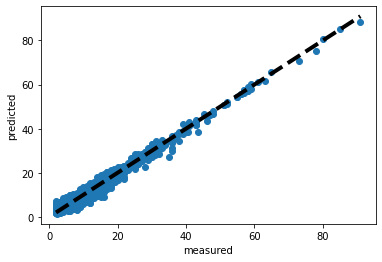

In [15]:
fig, ax = plt.subplots()
ax.scatter(trainY,trainPredict)
ax.plot([trainY.min(), trainY.max()], [trainY.min(), trainY.max()], 'k--', lw=4)
ax.set_xlabel('measured')
ax.set_ylabel('predicted')
plt.show()

#### Scatter plot representing the model predictions on test set

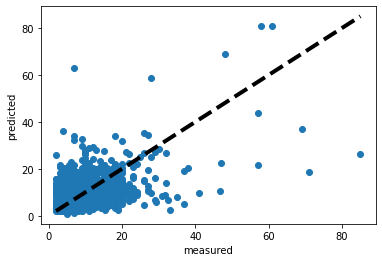

In [16]:
fig, ax = plt.subplots()
ax.scatter(testY,testPredict)
ax.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'k--', lw=4)
ax.set_xlabel('measured')
ax.set_ylabel('predicted')
plt.show()

#### Model loss Vs validation loss

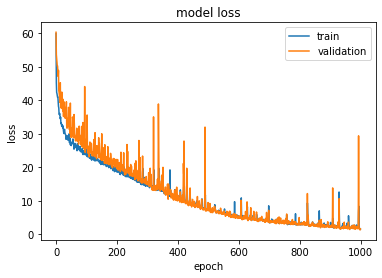

In [17]:
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

#### Loss (MSE) on test data

In [18]:
mse = mean_squared_error(testY,testPredict)
print(mse)

35.50926819669187
